# FOLPS Run Demo (Numpy)
This notebook demonstrates how to use FOLPS to compute the power spectrum and bispectrum.

### Set the backend
Select the backend (`numpy` or `jax`). In this notebook, we use `numpy`.  

In [ ]:
classy = {'k': k_arr, 'pk': pk_arr}

# kwargs used by other parts of the notebook
kwargs = {'z': 0.57,
          'h': 0.67,
          'Omega_m': 0.3201483855293351,
          'f0': 0.7866042388430217,
          'fnu': 0.02988290652026194}

pars = [b1, b2, bs, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP, X_Fog_pk]
bpars = [b1, b2, bs, c1, c2, Bshot, Pshot, X_FoG_bk]


matrix = FOLPS.MatrixCalculator(use_TNS_model=False) 
mmatrices = matrix.get_mmatrices()

nonlinear = FOLPS.NonLinearPowerSpectrumCalculator(mmatrices=mmatrices, kernels='fk', **kwargs)
table, table_now = nonlinear.calculate_loop_table(k=classy['k'], pklin=classy['pk'],cosmo=None, **kwargs)


multipoles = FOLPS.RSDMultipolesPowerSpectrumCalculator(model=model) 
P0, P2, P4  = multipoles.get_rsd_pkell(kobs=k_ev, qpar=qpar, qper=qper, pars=pars,
                                       table=table, table_now=table_now,
                                       bias_scheme=bias_scheme, damping=damping
                                       )


bispectrum = FOLPS.BispectrumCalculator(model = model)

B000, B110, B220, B202, B022, B112 = bispectrum.Sugiyama_Bell(f=f0, bpars=bpars,
                                       k_pkl_pklnw=k_pkl_pklnw, 
                                       k1k2pairs=k1k2T, qpar=qpar, qper=qper, 
                                       multipoles = ['B000', 'B110', 'B220', 'B202', 'B022', 'B112'],
                                       bias_scheme=bias_scheme
                                       )

#Scoccimarro basis
B0,B2,B4,x = bispectrum.Scoccimarro_Bell(k1k2k3triplets=k1k2k3triplets, f=f0, bpars=bpars,
                                        qpar=qpar, qperp=qper, k_pkl_pklnw=k_pkl_pklnw,  bias_scheme=bias_scheme)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
os.environ["FOLPS_BACKEND"] = "numpy"  #'numpy' or 'jax'
sys.path.append('../folps')
import folps as FOLPS
os.system('pwd');

✅ Using NumPy with CPU.
/global/cfs/cdirs/desicollab/users/hernannb/__FOLPS_tutorial/part1


### Settings

In [2]:
model = 'FOLPSD'     ## it can be 'FOLPSD', 'TNS' or 'EFT'.  default is 'EFT' 
damping = 'lor'      ## it can be 'lor' or 'exp' or damping = None.
use_TNS_model=False  ## True for TNS, default is False
bias_scheme='folps'  ## folps (mcdonald), classpt (assassi) 

if model == 'TNS':
    use_TNS_model=True 
    if damping == None:
        damping = 'lor'
if model == 'EFT':
    damping = None 

### Linear power spectrum  
The linear power spectrum can be computed using CLASS/CAMB. If CLASS/CAMB is not available, it will be loaded automatically instead.  
Additionally, some cosmological parameters must be provided as input (see `kwargs`).  

In [3]:
use_class = False
try:
    # try to import the CLASS-based runner; if Class isn't installed it will load a precomputed file
    from cosmo_class import run_class
    from classy import Class as _Class  # noqa: F401
except Exception:
    use_class = False

if use_class:
    classy  = run_class(h = 0.67, ombh2 = 0.02242, omch2 = 0.117, omnuh2 = 0.0004442, 
                        As = 2e-9, ns = 0.965, z = 0.57, z_scale=None,
                        N_ur = 2.0328,
                        khmin = 0.0001, khmax = 2.0, nbk = 1000, spectra = 'cb')
else:
    # Fallback: read precomputed k, pk from the repository file (do not create a cosmo object)
    data_path = 'pk_linear_simtocmass.txt'
    k_arr, pk_arr = np.loadtxt(data_path, unpack=True)

    # Provide k and pk only
    classy = {'k': k_arr, 'pk': pk_arr}

# kwargs used by other parts of the notebook
kwargs = {'z': 0.57,
          'h': 0.67,
          'Omega_m': 0.3201483855293351,
          'f0': 0.7866042388430217,
          'fnu': 0.02988290652026194}

### Nuisance parameters  
Set the nuisance parameters (bias, EFT, stochastic terms).  
Also specify the Alcock–Paczynski parameters `qpar` and `qper`. 

In [4]:
# Bias parameters
b1 = 1.9
b2 = -0.46
bs = -4./7*(b1 - 1)
b3nl = 32./315*(b1 - 1)
# EFT parameters
alpha0 = 3                 #units: [Mpc/h]^2
alpha2 = -28.9             #units: [Mpc/h]^2
alpha4 = 0.0               #units: [Mpc/h]^2
ctilde = 0.0               #units: [Mpc/h]^4
# Stochatic parameters
PshotP = 1. / 0.0002118763
alphashot0 = 0.08
alphashot2 = -8.1          #units: [Mpc/h]^2
X_Fog_pk = 0
pars = [b1, b2, bs, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP, X_Fog_pk]

qpar, qper = 1,1 #FOLPS.qpar_qperp(Omega_fid=0.31, Omega_m=kwargs['Omega_m'], z_pk=kwargs['z'])

# Computation of $M$ matrices 
Compute the matrices required for the non-linear power spectrum.  
**They do not depend on cosmology**, so they are **calculated only once.** 

In [5]:
matrix = FOLPS.MatrixCalculator(A_full=True,use_TNS_model=use_TNS_model) # TNS model: use_TNS_model=True
mmatrices = matrix.get_mmatrices()

Loading matrices from matrices_nfftlog128_Afull-True_use_TNS-False.npy


# Power spectrum

In [6]:
# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 40) # array of k_ev in [h/Mpc]

In [7]:
%%time

## kernels can be 'fk' or 'EdS'
nonlinear = FOLPS.NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,kernels='fk',**kwargs)

## cosmo is the CLASS engine
table, table_nonwiggles = nonlinear.calculate_loop_table(k=classy['k'], pklin=classy['pk'],cosmo=None, **kwargs)

## model can be 'EFT', 'FOLPSD', 'TNS'. default is 'EFT'
multipoles = FOLPS.RSDMultipolesPowerSpectrumCalculator(model=model) 

pkl0, pkl2, pkl4  = multipoles.get_rsd_pkell(kobs=k_ev, qpar=qpar, qper=qper, pars=pars,
                                       table=table, table_now=table_nonwiggles,
                                       bias_scheme=bias_scheme, damping=damping
                                       )

CPU times: user 147 ms, sys: 59 ms, total: 206 ms
Wall time: 335 ms


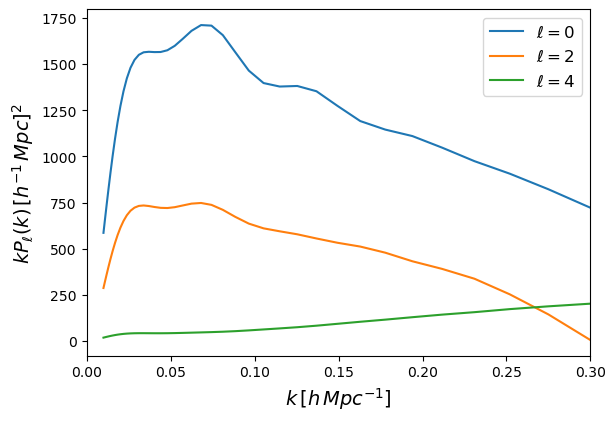

In [8]:
fig, axs = plt.subplots(figsize=(6.5, 4.5))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(k_ev, k_ev * pkl0, label=r'$\ell = 0$')
axs.plot(k_ev, k_ev * pkl2, label=r'$\ell = 2$')
axs.plot(k_ev, k_ev * pkl4, label=r'$\ell = 4$')

axs.set_xlim([0, 0.3])
axs.legend(fontsize=12, loc='best')

plt.show()


## Bispectrum
Set the nuisance parameters for the bispectrum computation.  

In [9]:
#pars for Bispectrum
Pshot = 0
Bshot = 0
c1=0
c2=0
X_FoG_bk=1

bpars = [b1, b2, bs, c1, c2, Bshot, Pshot, X_FoG_bk]

#get linear components of power spectrum
linear=nonlinear.get_linear(classy['k'], classy['pk'], pknow=None, cosmo=None, **kwargs)   

#get f0
f0 = FOLPS.get_f0(kwargs['z'],kwargs['Omega_m']) 

k_pkl_pklnw = np.array([linear['k'], linear['pk_l'],linear['pk_l_NW']])

## Sugiyama basis

In [10]:
k_ev = np.linspace(0.01,0.2, num = 40) 
k1k2T =np.vstack([k_ev,k_ev]).T   # List of pairs of k. (B=B(k1,k2))

In [11]:
%%time
#A single Bispectrum CLASS, with the option to compute Sugiyama or Scoccimarro
bispectrum = FOLPS.BispectrumCalculator(model = model)

#Sugiyama basis
B000, B110, B220, B202, B022, B112 = bispectrum.Sugiyama_Bell(
        f=f0,  
        bpars=bpars,
        k_pkl_pklnw=k_pkl_pklnw, 
        k1k2pairs=k1k2T, qpar=1, qper=1, precision=[8,10,10], 
        damping='lor',
        multipoles = ['B000', 'B110', 'B220', 'B202', 'B022', 'B112'],
        renormalize = True,
        interpolation_method='linear',
        bias_scheme='folps'
    )

CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 9.97 ms


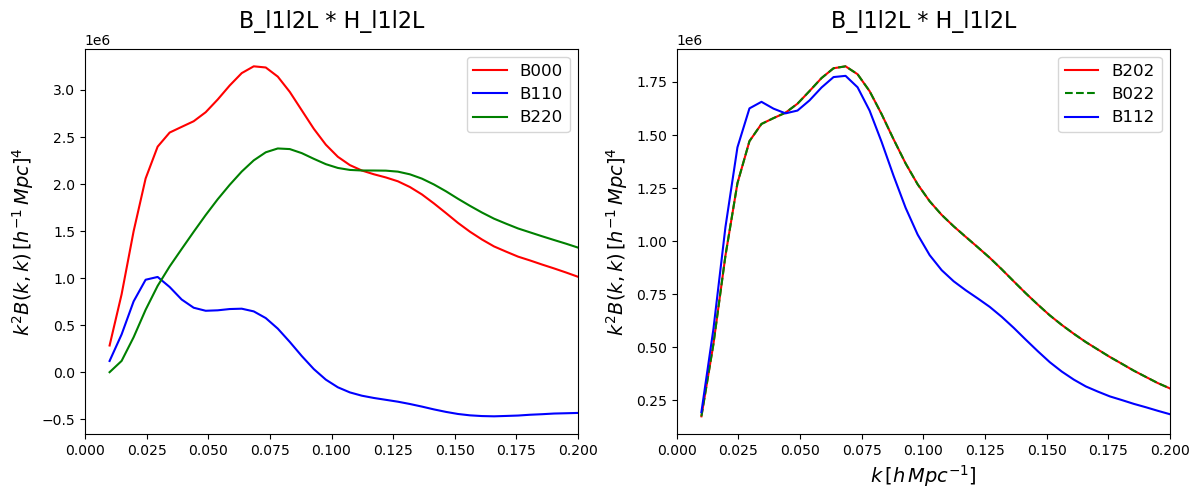

In [12]:
xmax=0.2

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[0].plot(k_ev, k_ev**2 * B000, label=r'B000', ls='-', color='red')
axs[0].plot(k_ev, k_ev**2 * B110, label=r'B110', ls='-', color='blue')
axs[0].plot(k_ev, k_ev**2 * B220, label=r'B220', ls='-', color='green')
axs[0].set_xlim([0, xmax])
axs[0].legend(fontsize=12, loc='best')
axs[0].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15);

axs[1].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize=14)
axs[1].set_ylabel(r'$k^2 B(k,k) \, [h^{-1} \,  Mpc]^4$', fontsize=14)
axs[1].plot(k_ev, k_ev**2 * B202, label=r'B202', ls='-', color='red')
axs[1].plot(k_ev, k_ev**2 * B022, label=r'B022', ls='--', color='green')
axs[1].plot(k_ev, k_ev**2 * B112, label=r"B112", ls='-', color='blue')

axs[1].set_xlim([0, xmax])
axs[1].legend(fontsize=12, loc='best')
axs[1].set_title('B_l1l2L * H_l1l2L', fontsize=16, pad=15);

## Run 2D multipoles


In [13]:
def reconstruct_symmetric(Btri, Nk):
    i, j = np.tril_indices(Nk)
    B = np.zeros((Nk, Nk))
    B[i, j] = Btri
    B[j, i] = Btri
    return B


def reconstruct_B202_B022(B202_tri, B022_tri, Nk):
    i, j = np.tril_indices(Nk)

    B202 = np.zeros((Nk, Nk))
    B022 = np.zeros((Nk, Nk))

    # Lower triangle (direct)
    B202[i, j] = B202_tri
    B022[i, j] = B022_tri

    # Upper triangle (cross-fill)
    B202[j, i] = B022_tri
    B022[j, i] = B202_tri

    return B202, B022

In [14]:
k_ev = np.linspace(0.01, 0.2, num=40)
Nk = len(k_ev)

# LOWER triangular indices (k1 >= k2)
i, j = np.tril_indices(Nk)

k1k2pairs = np.column_stack((k_ev[i], k_ev[j]))

In [15]:
%%time
Bk2D = bispectrum.Sugiyama_Bell(
        f=f0,  
        bpars=bpars,
        k_pkl_pklnw=k_pkl_pklnw, 
        k1k2pairs=k1k2pairs, qpar=1, qper=1, precision=[8,10,10], 
        damping='lor',
        multipoles = ['B000', 'B110', 'B220', 'B202', 'B022', 'B112'],
        renormalize = True,
        interpolation_method='linear'
    )

B000_2D, B110_2D, B220_2D, B202_2D, B022_2D, B112_2D = Bk2D

B000_grid = reconstruct_symmetric(B000_2D, Nk)
B110_grid = reconstruct_symmetric(B110_2D, Nk)
B220_grid = reconstruct_symmetric(B220_2D, Nk)
B112_grid = reconstruct_symmetric(B112_2D, Nk)

B202_grid, B022_grid = reconstruct_B202_B022(
    B202_2D, B022_2D, Nk
)

CPU times: user 152 ms, sys: 112 ms, total: 265 ms
Wall time: 264 ms


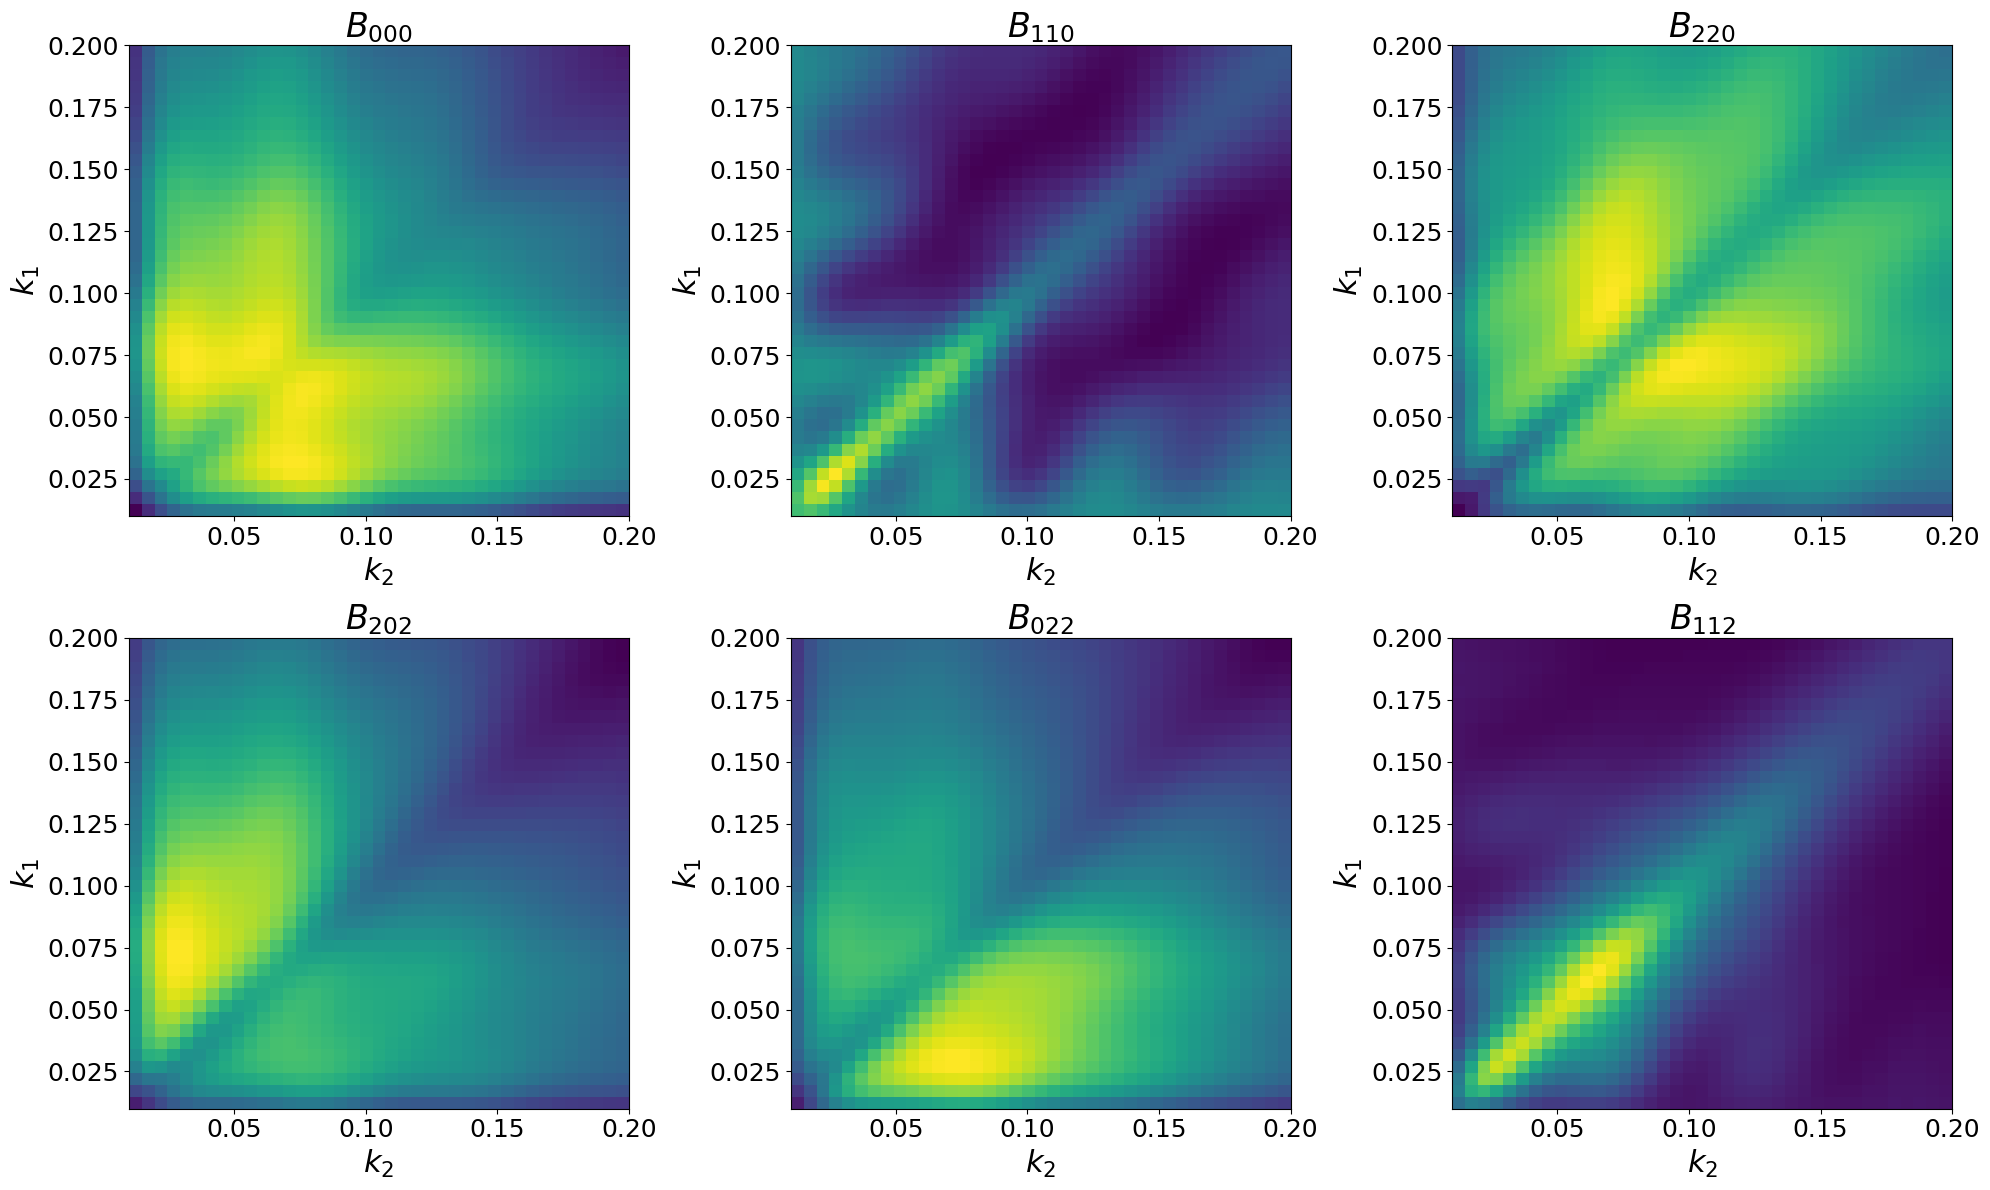

In [16]:
k1_vals = np.unique(k1k2pairs[:,0])
k2_vals = np.unique(k1k2pairs[:,1])

B000_scaled = B000_grid * k2_vals[:, None] * k1_vals[None, :]
B110_scaled = B110_grid * k2_vals[:, None] * k1_vals[None, :]
B220_scaled = B220_grid * k2_vals[:, None] * k1_vals[None, :]
B202_scaled = B202_grid * k2_vals[:, None] * k1_vals[None, :]
B022_scaled = B022_grid * k1_vals[:, None] * k2_vals[None, :]
B112_scaled = B112_grid * k2_vals[:, None] * k1_vals[None, :]

fig, axes = plt.subplots(2, 3, figsize=(20,12))

fs=24
fsk=22
fsl=18
showbar=False
# B000 imshow
im0 = axes[0,0].imshow(B000_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,0].set_title(r"$B_{000}$", fontsize=fs)
axes[0,0].set_xlabel("$k_2$", fontsize=fsk)
axes[0,0].set_ylabel("$k_1$", fontsize=fsk)
axes[0,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im0, ax=axes[0,0])

# B110 imshow
im1 = axes[0,1].imshow(B110_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,1].set_title(r"$B_{110}$", fontsize=fs)
axes[0,1].set_xlabel("$k_2$", fontsize=fsk)
axes[0,1].set_ylabel("$k_1$", fontsize=fsk)
axes[0,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im1, ax=axes[0,1])


# B110 imshow
im2 = axes[0,2].imshow(B220_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[0,2].set_title(r"$B_{220}$", fontsize=fs)
axes[0,2].set_xlabel("$k_2$", fontsize=fsk)
axes[0,2].set_ylabel("$k_1$", fontsize=fsk)
axes[0,2].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[0,2])

# B110 imshow
im2 = axes[1,0].imshow(B202_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,0].set_title(r"$B_{202}$", fontsize=fs)
axes[1,0].set_xlabel("$k_2$", fontsize=fsk)
axes[1,0].set_ylabel("$k_1$", fontsize=fsk)
axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)

axes[1,0].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im2, ax=axes[1,0])





im3 = axes[1,1].imshow(B022_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,1].set_title(r"$B_{022}$", fontsize=fs)
axes[1,1].set_xlabel("$k_2$", fontsize=fsk)
axes[1,1].set_ylabel("$k_1$", fontsize=fsk)

axes[1,1].tick_params(axis='both', which='major', labelsize=fsl)
if showbar:
    fig.colorbar(im3, ax=axes[1,1])






im3 = axes[1,2].imshow(B112_scaled[1:,1:], 
                     origin='lower',
                     extent=[k2_vals.min(), k2_vals.max(), 
                             k1_vals.min(), k1_vals.max()],
                     aspect='auto')
axes[1,2].set_title(r"$B_{112}$", fontsize=fs)
axes[1,2].set_xlabel("$k_2$", fontsize=fsk)
axes[1,2].set_ylabel("$k_1$", fontsize=fsk)
axes[1,2].tick_params(axis='both', which='major', labelsize=fsl)

if showbar:
    fig.colorbar(im3, ax=axes[1,2])



plt.tight_layout()
plt.show()


## Scoccimarro basis
Triangles are k1<k2<k3, and veck1 + veck2 + veck3 = 0.

Also, the angles in an equilateral triangle are 120 degrees, or hatk1.hatk2 = -0.5

In [17]:
k1T, k2T, k3T = np.loadtxt("k1k2k3.txt", unpack=True)
k1k2k3triplets = np.column_stack((k1T, k2T, k3T))   # List of triplets of k. (B=B(k1,k2,k3))

In [18]:
%%time
bispectrum = FOLPS.BispectrumCalculator(model = 'FOLPSD')

#Scoccimarro basis
B0,B2,B4,x=bispectrum.Scoccimarro_Bell(k1k2k3triplets=k1k2k3triplets,
                                       f=f0, 
                                       bpars=bpars,
                                       qpar=qpar,
                                       qperp=qper,
                                       k_pkl_pklnw=k_pkl_pklnw, 
                                       precision=[10,10], damping='lor',interpolation_method='cubic')

CPU times: user 8.8 ms, sys: 0 ns, total: 8.8 ms
Wall time: 11.9 ms


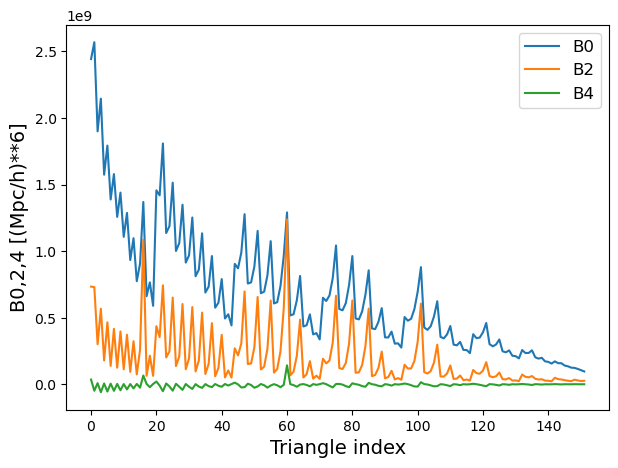

In [19]:
fig, axs = plt.subplots(figsize=(7,5))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'B0,2,4 [(Mpc/h)**6]', fontsize =  14)


axs.plot(B0, label=r'B0')
axs.plot(B2, label=r'B2')
axs.plot(B4, label=r'B4')

axs.legend(fontsize=12, loc='best')

plt.show()

In [20]:
#extract equilateral and isosceles triangles
equilateral_n = []     
isosceles_n = []       

for i, (a, b, c) in enumerate(k1k2k3triplets):
    if a == b == c:
        equilateral_n.append(i)
    elif a == b or a == c or b == c:
        isosceles_n.append(i)
        
equilateral_n  = np.array(equilateral_n)    
isosceles_n = np.array(isosceles_n)

B0_equilateral=np.stack((equilateral_n, B0[equilateral_n]))
B0_isosceles=np.stack((isosceles_n, B0[isosceles_n]))


B2_equilateral=np.stack((equilateral_n, B2[equilateral_n]))
B2_isosceles=np.stack((isosceles_n, B2[isosceles_n]))

B4_equilateral=np.stack((equilateral_n, B4[equilateral_n]))
B4_isosceles=np.stack((isosceles_n, B4[isosceles_n]))

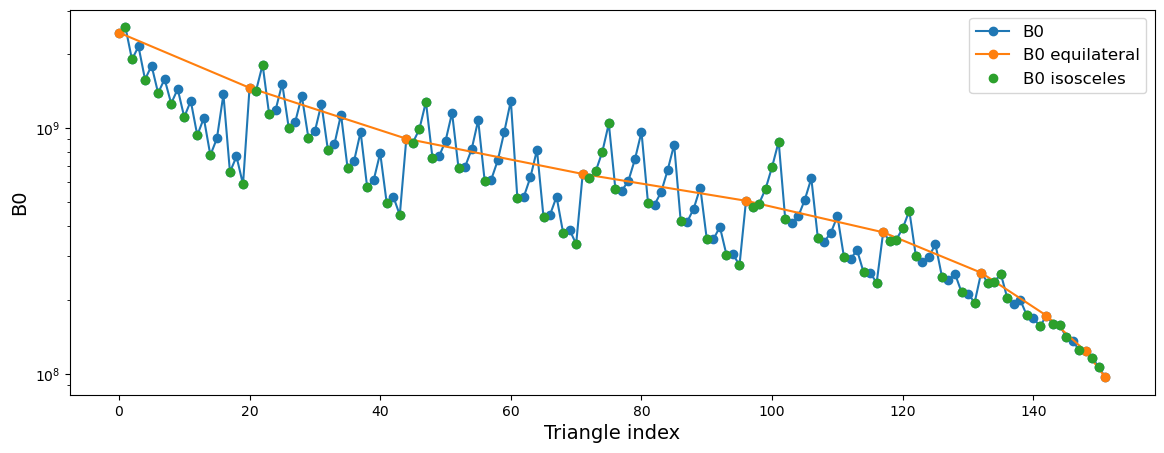

In [21]:
## check fig.2 of https://arxiv.org/pdf/1606.00439  CMASS NGC

fig, axs = plt.subplots(figsize=(14,5))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'B0', fontsize =  14)

x=np.arange(len(B0))
axs.semilogy(x,B0, 'o-', label = r'B0')
axs.semilogy(B0_equilateral[0],B0_equilateral[1], 'o-', label = r'B0 equilateral')
axs.semilogy(B0_isosceles[0],B0_isosceles[1], 'o', label = r'B0 isosceles')

axs.legend(fontsize=12, loc='best')


plt.show()

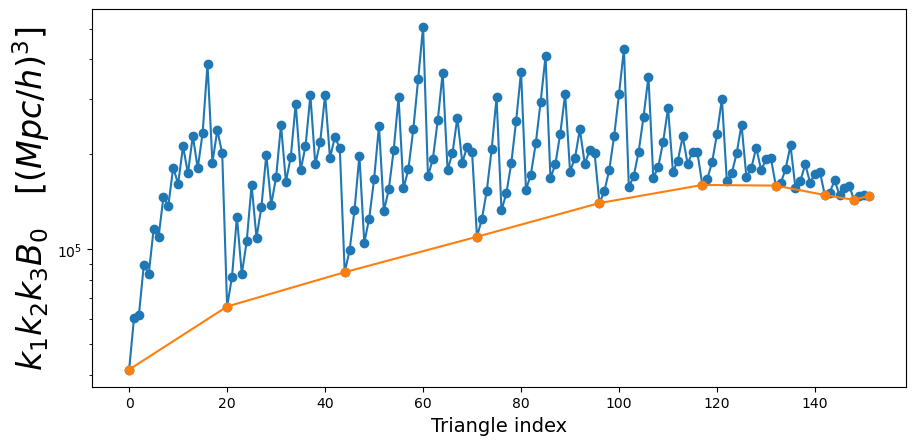

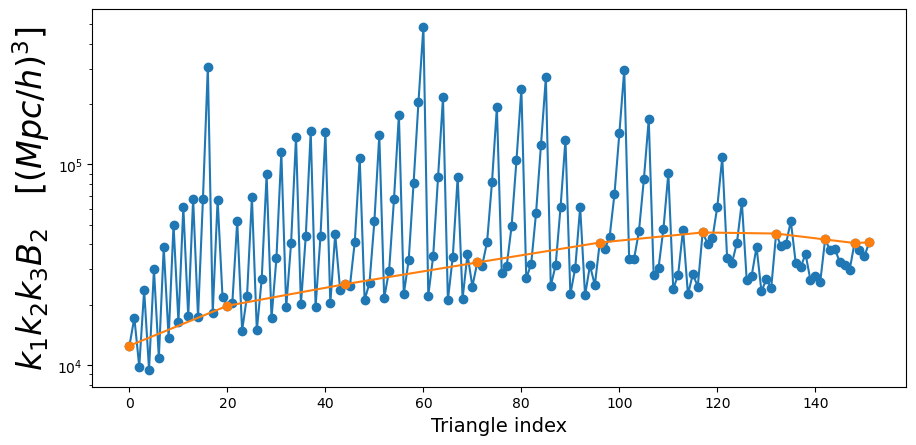

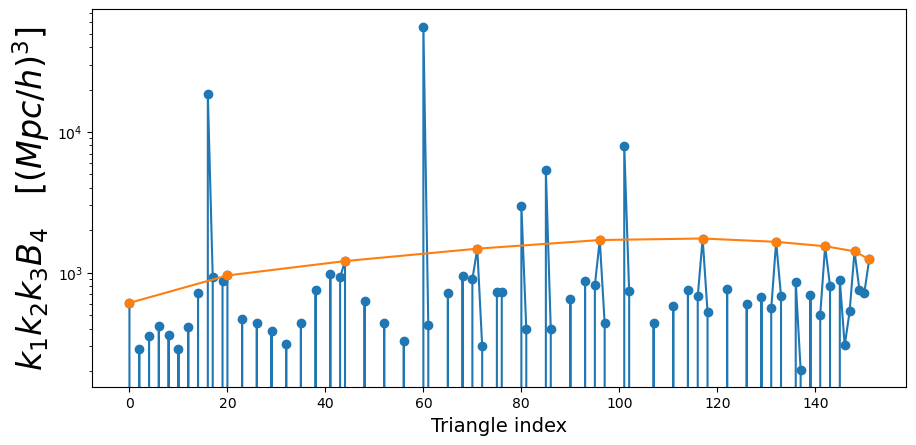

In [22]:
## check fig.2 of https://arxiv.org/pdf/2503.09714 (but her is a different cosmology)
rs=0.7
x=np.arange(len(B0))
en=equilateral_n

fig, axs = plt.subplots(figsize=(15*rs,7*rs))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_0 \quad [(Mpc/h)^3]$', fontsize =  24)
axs.semilogy(x,k1T*k2T*k3T*B0, 'o-')
axs.semilogy(B0_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B0_equilateral[1], 'o-')
plt.show()

fig, axs = plt.subplots(figsize=(15*rs,7*rs))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_2 \quad [(Mpc/h)^3]$', fontsize =  24)
x=np.arange(len(B0))
axs.semilogy(x,k1T*k2T*k3T*B2, 'o-')
axs.semilogy(B2_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B2_equilateral[1], 'o-')
plt.show()

fig, axs = plt.subplots(figsize=(15*rs,7*rs))
axs.set_xlabel(r'Triangle index', fontsize =  14)
axs.set_ylabel(r'$k_1 k_2k_3 B_4 \quad [(Mpc/h)^3]$', fontsize =  24)
axs.semilogy(x,k1T*k2T*k3T*B4, 'o-')
axs.semilogy(B4_equilateral[0],k1T[en]*k2T[en]*k3T[en]*B4_equilateral[1], 'o-')

plt.show()